In [1]:
%pip install yfinance
%pip install matplotlib
%pip install seaborn
%pip install plotly




Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


**Import libraries**

In [2]:
from pandas_datareader import data as pdr
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import statsmodels.tsa.stattools as ts


# 1. OptiCat Pair Strategy 2024

## OptiCat Idea
In light of the dynamic and interconnected nature of the energy sector, OptiCat has strategically selected a pair trading strategy to navigate the complexities of this market.
OptiCat has decided to trade using exclusively energy firms’ stocks due to their high degree of correlation.

## Pair Strategy
The idea behind this technique is to profit on the oscilations of relative growth between two companies.
In order to profit from the relative movements of two positions or assets that are directly or adversely connected, one might use a pair strategy in trading or investing. This include purchasing one stock and selling another at the same time. This strategy's justification is to reduce risk by taking advantage of the anticipated performance difference between the two stocks. For example, if a trader believes that one stock will do better than another, they would go long on the stronger one and short on the weaker one. The effectiveness of a pair strategy depends on carefully examining and analyzing pairs to find those that are most likely to show a notable divergence in their price movements. In order to profit from both upward and downward market movements while limiting exposure to larger market risks, this approach is frequently utilized in market-neutral trading.

## Why the energy sector 
Energy stocks frequently demonstrate a high degree of correlation owing to several shared factors influencing the entire industry. Key among these is the impact of commodity prices, particularly crude oil and natural gas, which significantly affect companies involved in the energy sector. Macroeconomic conditions also play a vital role, with energy demand closely tied to economic growth or contraction. Global events, such as geopolitical tensions or natural disasters, can disrupt energy supply chains and affect multiple companies simultaneously. Regulatory changes, technological advancements, and overall market sentiment further contribute to the correlation within the energy sector.


# 2. Data

## Retrive data

For each stock we extrapolate hourly and daily data from Yahoo Finance based on tickers provided in a list.

### Stock pick

We choose energy sector stocks from **S&P 500** because, as explained previously, in this sector there has been a high correlation in the past. Therefore, we picked the 10 stocks with highest market cap in this sector. 

**STOCK LIST:**
- Exxon Mobil Corporation [XOM]
- Chevron Corporation [CVX]
- ConocoPhillips [COP]
- Schlumberger Limited [SLB]
- EOG Resources, Inc. [EOG]
- Marathon Petroleum Corporation [MPC]
- Phillips 66 [PSX]
- Enterprise Products Partners L.P. [EPD]
- Pioneer Natural Resources Company [PXD]
- Occidental Petroleum Corporation [OXY]




## Hourly data
We get hourly data of our stocks as well as S&P 500 index to be able to compare returns of our strategy against a simple benchmark.

In [3]:
# Companies tickers list
ticker_list=['XOM', 'CVX', 'COP' , 'SLB', 'EOG','MPC', 'PSX', 'EPD', 'PXD', 'OXY', '^GSPC']

# Get data for last 730 days on hounrly time frame
df_hourly = yf.download(ticker_list, period="730d", interval="1h")['Adj Close']

# Rename sp500
df_hourly = df_hourly.rename(columns={'^GSPC':'SP500'})


[*********************100%%**********************]  11 of 11 completed


In [4]:
# Check info of our data frame
df_hourly.info()
print(20*'**'+ '\n')

# Count NaN values in each column
nan_counts_hourly = df_hourly.isna().sum()
display(nan_counts_hourly)
print(20*'**'+ '\n')

# Let's check the index. We want date as index
df_hourly.index

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5094 entries, 2021-04-15 09:30:00-04:00 to 2024-03-08 15:30:00-05:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   COP     5094 non-null   float64
 1   CVX     5094 non-null   float64
 2   EOG     5072 non-null   float64
 3   EPD     5094 non-null   float64
 4   MPC     5094 non-null   float64
 5   OXY     5094 non-null   float64
 6   PSX     5094 non-null   float64
 7   PXD     5094 non-null   float64
 8   SLB     5024 non-null   float64
 9   XOM     5094 non-null   float64
 10  SP500   5094 non-null   float64
dtypes: float64(11)
memory usage: 477.6 KB
****************************************



Ticker
COP       0
CVX       0
EOG      22
EPD       0
MPC       0
OXY       0
PSX       0
PXD       0
SLB      70
XOM       0
SP500     0
dtype: int64

****************************************



DatetimeIndex(['2021-04-15 09:30:00-04:00', '2021-04-15 10:30:00-04:00',
               '2021-04-15 11:30:00-04:00', '2021-04-15 12:30:00-04:00',
               '2021-04-15 13:30:00-04:00', '2021-04-15 14:30:00-04:00',
               '2021-04-15 15:30:00-04:00', '2021-04-16 09:30:00-04:00',
               '2021-04-16 10:30:00-04:00', '2021-04-16 11:30:00-04:00',
               ...
               '2024-03-07 13:30:00-05:00', '2024-03-07 14:30:00-05:00',
               '2024-03-07 15:30:00-05:00', '2024-03-08 09:30:00-05:00',
               '2024-03-08 10:30:00-05:00', '2024-03-08 11:30:00-05:00',
               '2024-03-08 12:30:00-05:00', '2024-03-08 13:30:00-05:00',
               '2024-03-08 14:30:00-05:00', '2024-03-08 15:30:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Datetime', length=5094, freq=None)

For now, we keep data in `wide format`
- each stock is one column
- in all columns, the variable is the same: `adjusted close price`
- row index is date

In [5]:
# lets check what is maximum number of consencutive NaN values
# If there is only a few we can decide to interpolate data with back fill or bfill for example to get missing data

def max_consecutive_nan(column):
    max_consecutive = 0
    current_consecutive = 0

    for value in column:
        if pd.isna(value):
            current_consecutive += 1
            max_consecutive = max(max_consecutive, current_consecutive)
        else:
            current_consecutive = 0

    return max_consecutive

# We apply function to each column 
max_nan_values = df_hourly.apply(max_consecutive_nan)
print(max_nan_values)

Ticker
COP      0
CVX      0
EOG      7
EPD      0
MPC      0
OXY      0
PSX      0
PXD      0
SLB      7
XOM      0
SP500    0
dtype: int64


Since there are ***max 7 consecutive NaN values*** we decide to interpolate data instead of dropping the whole series.

In [6]:
# Fill missing data with last available data point before the sequence of NaN values
df_filled_hourly = df_hourly.ffill()
df_filled_hourly = df_filled_hourly.bfill()

# We make sure there is no more missing values in each of our time series (DataFrame)
missing = df_filled_hourly.isna().sum().sum()
print(f'There are {missing} missing values in our DataFrame of hourly prices.')

There are 0 missing values in our DataFrame of hourly prices.


### Split data

We need to split data at least to  *in-sample* and *out-of-sample/test* data.

- `in-sample`: analyze data, build strategy, choose the best parameters/thresholds for our signals
- `out-of-sample`: apply your strategy, see how it performs without knowing future data

We will split data by 70/30 rule which means 70% of dataset will be used for training and remaining 30% for testing our strategy.

In [7]:
# Remove datetime index for slicing needs
df_filled_hourly = df_filled_hourly.reset_index(drop=False)

In [8]:
# Split data 70/30

length = len(df_filled_hourly)

# Train data is 70% of all available data
df_train_hourly = df_filled_hourly.loc[:int(length*0.7)]
df_train_hourly.to_csv('data/pair_train_h.csv')

# Test data is remaining 30% of data
df_test_hourly = df_filled_hourly.loc[int(length*0.7+1):]
df_test_hourly.to_csv('data/pair_test_h.csv')

In [9]:
# Check if data is continous without dropped rows (check if index is correct)
display(df_train_hourly.tail(1))
display(df_test_hourly.head(1))


Ticker                  Datetime         COP         CVX     EOG        EPD  \
3565   2023-04-25 12:30:00-04:00  101.120003  168.869995  116.18  26.545601   

Ticker         MPC      OXY        PSX         PXD        SLB         XOM  \
3565    123.059998  60.9221  99.309998  222.160004  48.314999  115.985802   

Ticker        SP500  
3565    4086.409912

Ticker                  Datetime         COP      CVX     EOG   EPD  \
3566   2023-04-25 13:30:00-04:00  101.769997  169.375  116.93  26.6   

Ticker         MPC        OXY        PSX         PXD    SLB         XOM  \
3566    123.209999  61.450001  99.849998  223.483994  48.98  116.510002   

Ticker        SP500  
3566    4082.919922

## Daily data
We get daily data of our stocks as well as S&P 500 index to be able to compare returns of our strategy against a simple benchmark.

In [10]:
# Set analyzed period
start_date="2000-01-01"
end_date="2023-12-31"

# Get data from yahoo finance
df_daily = yf.download(ticker_list, start=start_date, end=end_date, interval="1d")['Adj Close']

# Rename sp500
df_daily = df_daily.rename(columns={'^GSPC':'SP500'})

[*********             18%%                      ]  2 of 11 completed

[*********************100%%**********************]  11 of 11 completed


In [11]:
# Explore dataframe
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6037 entries, 2000-01-03 to 2023-12-29
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   COP     6037 non-null   float64
 1   CVX     6037 non-null   float64
 2   EOG     6037 non-null   float64
 3   EPD     6037 non-null   float64
 4   MPC     3150 non-null   float64
 5   OXY     6037 non-null   float64
 6   PSX     2949 non-null   float64
 7   PXD     6037 non-null   float64
 8   SLB     6037 non-null   float64
 9   XOM     6037 non-null   float64
 10  SP500   6037 non-null   float64
dtypes: float64(11)
memory usage: 566.0 KB


In [12]:
# Count NaN values in each column
nan_counts = df_daily.isna().sum()

# Display the result
print(nan_counts)

Ticker
COP         0
CVX         0
EOG         0
EPD         0
MPC      2887
OXY         0
PSX      3088
PXD         0
SLB         0
XOM         0
SP500       0
dtype: int64


In [13]:
# We apply function to each column 
max_nan_values_daily = df_daily.apply(max_consecutive_nan)
print(max_nan_values_daily)

Ticker
COP         0
CVX         0
EOG         0
EPD         0
MPC      2887
OXY         0
PSX      3088
PXD         0
SLB         0
XOM         0
SP500       0
dtype: int64


In [14]:
# Drop columns of MPC and PSX

df_daily_filtered = df_daily.drop(columns=['MPC', 'PSX'])

# Reset index
df_daily_filtered=df_daily_filtered.reset_index(drop=False)


### Split data

We need to split data at least to  *in-sample* and *out-of-sample/test* data.

- `in-sample`: analyze data, build strategy, choose the best parameters/thresholds for our signals
- `out-of-sample`: apply your strategy, see how it performs without knowing future data

We will split data by 70/30 rule which means 70% of dataset will be used for training and remaining 30% for testing our strategy.

In [15]:
# Split data 70/30

length = len(df_daily_filtered)

# Train data is 70% of all available data
df_train_daily = df_daily_filtered.loc[:int(length*0.7)]
df_train_daily.to_csv('data/pair_train_daily.csv')

# Test data is remaining 30% of data
df_test_daily = df_daily_filtered.loc[int(length*0.7+1):]
df_test_daily.to_csv('data/pair_test_daily.csv')

# 3. EDA

Explanatory Data Analysis (EDA) is a crucial initial step in the data analysis process, aiming to understand the structure, patterns, and anomalies within a dataset before applying more complex analytical or predictive models.

Consequently we decided to compute the percentage change, the cumulative return, correlation and cointegration test and stationarity (Augmented Dickey Fuller test) on the selected stocks and the S&P500.

We performed the EDA on both daily and hourly intervals.

## Hourly EDA

In [16]:
# Load csv of train data
df_train_h = pd.read_csv('data/pair_train_h.csv', index_col=0, parse_dates=True)

# Set index to date column
df_train_h.set_index('Datetime', inplace=True)

df_train_h.head()

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_64979/3719278443.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_train_h = pd.read_csv('data/pair_train_h.csv', index_col=0, parse_dates=True)


COP         CVX        EOG        EPD  \
Datetime                                                                 
2021-04-15 09:30:00-04:00  52.380001  103.959999  73.940002  23.250000   
2021-04-15 10:30:00-04:00  51.930000  103.019997  73.477501  23.200001   
2021-04-15 11:30:00-04:00  52.009998  103.010002  73.235001  23.250000   
2021-04-15 12:30:00-04:00  51.980000  103.160004  72.790001  23.282499   
2021-04-15 13:30:00-04:00  52.060001  103.449997  72.930000  23.165001   

                                 MPC        OXY        PSX         PXD  \
Datetime                                                                 
2021-04-15 09:30:00-04:00  53.459999  25.189899  78.889999  151.949997   
2021-04-15 10:30:00-04:00  53.380001  24.889900  78.639900  151.220001   
2021-04-15 11:30:00-04:00  53.639999  24.870001  78.639999  151.710007   
2021-04-15 12:30:00-04:00  53.529999  24.767900  78.532501  152.279999   
2021-04-15 13:30:00-04:00  53.790001  25.000000  78.839996  152.529999   

                                 SLB        XOM        SP500  
Datetime                                                      
2021-04-15 09:30:00-04:00  26.940001  57.160000  4157.410156  
2021-04-15 10:30:00-04:00  26.719999  56.919998  4159.020020  
2021-04-15 11:30:00-04:00  26.657499  57.029999  4163.899902  
2021-04-15 12:30:00-04:00  26.635000  56.980000  4165.020020  
2021-04-15 13:30:00-04:00  26.719999  57.000000  4168.620117

In [17]:
fig = px.line(df_train_h, x=df_train_h.index, y=df_train_h.columns, labels={'value': 'Adjusted Close Price', 'variable': 'Ticker'})
fig.update_layout(title='Adjusted Hourly Close Prices of Selected Stocks And S&P 500',
                  xaxis_title='Date',
                  yaxis_title='Adjusted Close Price')

# Show plot
fig.show()

In [18]:
# Make long format for pct_change calculation
df_long_h = pd.melt(df_train_h.reset_index(), id_vars=['Datetime'], var_name='ticker', value_name='price')

# Set index again
df_long_h.set_index('Datetime', inplace=True)

# Calculate pct change for each ticker
df_long_h['ret'] = df_long_h.groupby('ticker')['price'].pct_change()
df_long_h.dropna(inplace=True)


In [19]:
# Calculate cumulative return
# df_long_h = df_long_h.sort_values(['Datetime', 'ticker'])
df_long_h['cum_ret'] = df_long_h.groupby('ticker')['ret'].transform(lambda x: np.cumprod(1 + x))

In [20]:
# Assuming df_long_h is your DataFrame with 'Datetime', 'ticker', and 'cumulative_return' columns
fig = px.line(df_long_h, x=df_long_h.index, y='cum_ret', color='ticker',
              title='Cumulative Returns of Selected Stocks',
              labels={'cum_ret': 'Cumulative Return', 'ticker': 'Ticker'},
              line_shape='linear')

fig.update_layout(xaxis_title='Date', yaxis_title='Cumulative Return')
fig.show()


We calculated the cumulative returns for the chosen stocks. As portrayed in the graph, the cumulative return of the S&P 500, despite its significantly higher price compared to the individual stocks, is the lowest among them.

### Correlation test
Below we test the correlation among all the firms. As mentioned earlier, it is crucial to identify the pair with the highest coefficient in order to maximise the outcome.

The top 5 pairs and their correlations are shown below in the heatmap.

In [21]:
df_train_h.head()

COP         CVX        EOG        EPD  \
Datetime                                                                 
2021-04-15 09:30:00-04:00  52.380001  103.959999  73.940002  23.250000   
2021-04-15 10:30:00-04:00  51.930000  103.019997  73.477501  23.200001   
2021-04-15 11:30:00-04:00  52.009998  103.010002  73.235001  23.250000   
2021-04-15 12:30:00-04:00  51.980000  103.160004  72.790001  23.282499   
2021-04-15 13:30:00-04:00  52.060001  103.449997  72.930000  23.165001   

                                 MPC        OXY        PSX         PXD  \
Datetime                                                                 
2021-04-15 09:30:00-04:00  53.459999  25.189899  78.889999  151.949997   
2021-04-15 10:30:00-04:00  53.380001  24.889900  78.639900  151.220001   
2021-04-15 11:30:00-04:00  53.639999  24.870001  78.639999  151.710007   
2021-04-15 12:30:00-04:00  53.529999  24.767900  78.532501  152.279999   
2021-04-15 13:30:00-04:00  53.790001  25.000000  78.839996  152.529999   

                                 SLB        XOM        SP500  
Datetime                                                      
2021-04-15 09:30:00-04:00  26.940001  57.160000  4157.410156  
2021-04-15 10:30:00-04:00  26.719999  56.919998  4159.020020  
2021-04-15 11:30:00-04:00  26.657499  57.029999  4163.899902  
2021-04-15 12:30:00-04:00  26.635000  56.980000  4165.020020  
2021-04-15 13:30:00-04:00  26.719999  57.000000  4168.620117

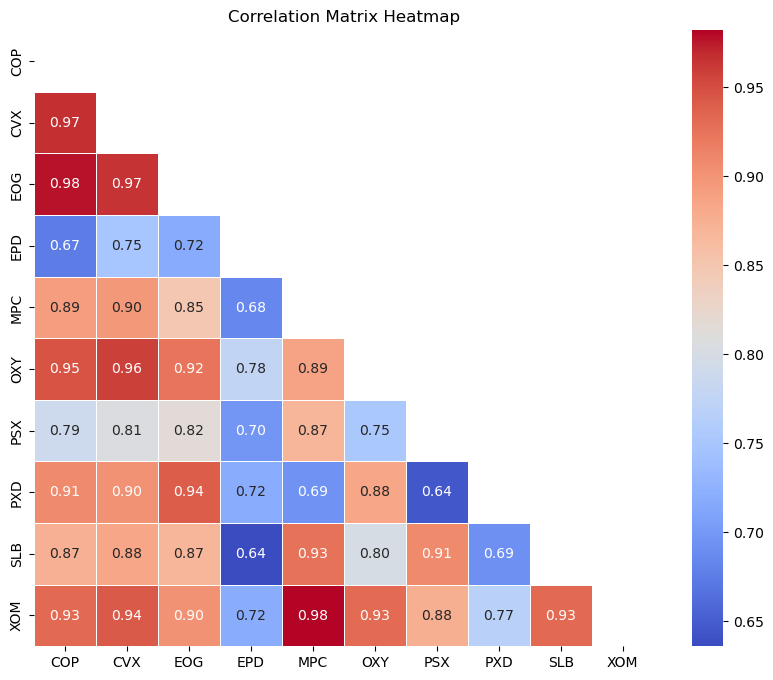

Top 5 Pairs Based on Correlation Score:
         pair  Correlation score
0  (XOM, MPC)           0.981986
1  (EOG, COP)           0.977609
2  (CVX, COP)           0.965830
3  (EOG, CVX)           0.965110
4  (OXY, CVX)           0.958520


In [22]:
# Drop SP500 column for statistical tests
df_train_h_stat = df_train_h.drop(columns='SP500')

corr_matrix_hourly = df_train_h_stat.corr()

# Exclude diagonal and upper triangle
np.fill_diagonal(corr_matrix_hourly.values, np.nan)
mask = np.triu(np.ones_like(corr_matrix_hourly, dtype=bool))
corr_matrix_hourly = corr_matrix_hourly.mask(mask)

# Plot correlation matric heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_hourly, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


# Find the top 3 pairs based on correlation score
top_pairs_cor_h = (corr_matrix_hourly.abs().stack()
              .sort_values(ascending=False)
              .head(5)
              .reset_index()
              .rename(columns={'level_0': 'Pair1', 'level_1': 'Pair2', 0: 'Correlation score'}))

top_pairs_cor_h['pair'] = top_pairs_cor_h.apply(lambda row: (row['Pair1'], row['Pair2']), axis=1)

# Print the top 5 pairs (lowest p-value)
print("Top 5 Pairs Based on Correlation Score:")
print(top_pairs_cor_h[['pair', 'Correlation score']])




### Cointegration test
The correlations between financial quantities are notoriously unstable. Nevertheless, correlations are regularly used in almost all multivariate financial problems. An alternative statistical measure to correlation is cointegration. This is probably a more robust measure of linkage between two financial quantities, but as yet there is little derviaties theory based on this concept.

Two stocks may be perfectly correlated over short timescales, yet diverge in the long run, with one growing and the other decaying. Conversely, two stocks may follow each other, never being more than a certain distance apart, but with any correlation, positive negaative or varying. If we are delta hedging, then maybe the short timescale orrelation matters, but not if we are holding stocks for a long time in an unhedged portfolio.

We are using augmented Engle-Granger two-step cointegration test.
Testing for cointegration. We want as low p-value as possible. Ideally < 2 %.

The top 3 pairs and their cointegrations are shown below the heatmap.

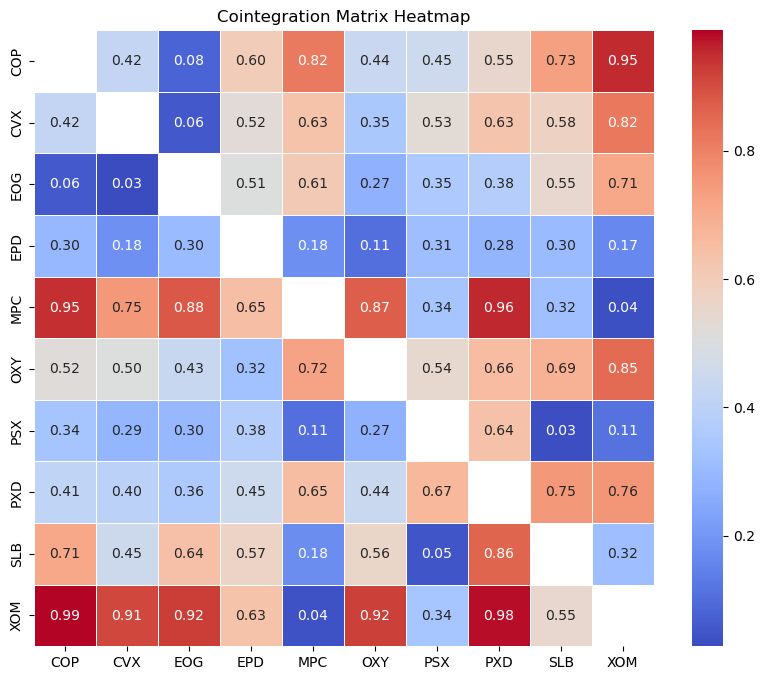

Top 3 Pairs Based on Cointegration Score:
         pair   P-value
0  (EOG, CVX)  0.027576
1  (PSX, SLB)  0.031701
2  (MPC, XOM)  0.037404


In [23]:
columns = df_train_h_stat.columns

# Initialize a matrix to store cointegration test results
coint_matrix_hourly = pd.DataFrame(index=columns, columns=columns)

# Perform cointegration tests for all pairs
for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            t,p,_ = ts.coint(df_train_h_stat[col1], df_train_h_stat[col2])
            coint_matrix_hourly.loc[col1, col2] = p

# Transform to numeric 
coint_matrix_hourly = coint_matrix_hourly.apply(pd.to_numeric, errors='coerce')


# Plot correlation matric heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(coint_matrix_hourly, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Cointegration Matrix Heatmap')
plt.show()

# Find the top 3 pairs based on cointegration score
top_pairs_coint_h = (coint_matrix_hourly.abs().stack()
              .sort_values(ascending=True)
              .head(3)
              .reset_index()
              .rename(columns={'level_0': 'Pair1', 'level_1': 'Pair2', 0: 'P-value'}))

top_pairs_coint_h['pair'] = top_pairs_coint_h.apply(lambda row: (row['Pair1'], row['Pair2']), axis=1)

# Print the top 3 pairs (lowest p-value)
print("Top 3 Pairs Based on Cointegration Score:")
print(top_pairs_coint_h[['pair', 'P-value']])


In [24]:
# Extract pairs from both DataFrames
pairs_df1 = set(top_pairs_cor_h['pair'])
pairs_df2 = set(top_pairs_coint_h['pair'])

# Find common pairs
common_pairs = pairs_df1.intersection(pairs_df2)

# Print common pairs
print("Common Pairs:")
for pair in common_pairs:
    print(pair)

Common Pairs:
('EOG', 'CVX')


After comparing correlation and cointegration pair (XOM,MPC) was drop due to worse cointegration results out of those two pairs. The pair we find in both lists of top cointegrated and correlated is **(EOG,CVX)**.

### Stationarity - Augmented Dickey Fuller test
Stationarity is the most commonly untestedassumption in time series analysis. We generally assume that data is stationary when the parameters of the data generating process do not change over time. Else consider two series: A and B. Series A will generate a stationary time series with fixed parameters, while B will change over time.

We will create a function that creates a z-score for probability density function. The probability density for a Gaussian distribution is:

$$ p(x) = \frac{1}{\sqrt{2\pi\sigma^{2}}}e^{-\frac{(x-\mu)^{2}}{2\sigma^{2}}}$$

In order to test for stationarity, we need to test for something called a *unit root*. Autoregressive unit root test are based the following hypothesis test:

$$
\begin{aligned}
H_{0} & : \phi =\ 1\ \implies y_{t} \sim I(0) \ | \ (unit \ root) \\
H_{1} & : |\phi| <\ 1\ \implies y_{t} \sim I(0) \ | \ (stationary)  \\
\end{aligned}
$$

It's referred to as a unit root tet because under the null hypothesis, the autoregressive polynominal of $ z_{t},\ \phi(z)= (1-\phi(z)) = 0$, has a root equal to unity. 

$ y_t $ is trend stationary under the null hypothesis. If $ y_t $ is then first differenced, it becomes:

$$
\begin{aligned}
\Delta y_{t} & = \delta\ + \Delta(z)_{t} \\
\Delta(z) & = \phi\Delta(z)_{t-1}\ +\ \varepsilon_{t}\ -\ \varepsilon_{t-1} \\
\end{aligned}
.$$

The test statistic is

$$ t_{\phi=1}=\frac{\hat{\phi}-1}{SE(\hat{\phi})}$$

$\hat{\phi}$ is the least square estimate and SE($\hat{\phi}$) is the usual standard error estimate. The test is a one-sided left tail test. If {$y_{t}$} is stationary, then it can be shown that

$$\sqrt{T}(\hat{\phi}-\phi)\xrightarrow[\text{}]{\text{d}}N(0,(1-\phi^{2}))$$

or 

$$\hat{\phi}\overset{\text{A}}{\sim}N\bigg(\phi,\frac{1}{T}(1-\phi^{2}) \bigg)$$

andit follows that $t_{\phi=1}\overset{\text{A}}{\sim}N(0,1).$ However, under the null hypothesis of non-stationarity, the above result gives

$$
\hat{\phi}\overset{\text{A}}{\sim} N(0,1)
$$

The following function will allow us to check for stationarity using the Augmented Dickey Fuller (ADF) test.

Below are the p-values for each stock.

In [25]:
def stationarity_test(X, cutoff=0.02):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = round(ts.adfuller(X)[1], ndigits=4)
    if pvalue <= cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

In [26]:
# Check for stationarity in our stocks
for ticker in df_train_h_stat.columns:
    stationarity_test(df_train_h_stat[ticker])

p-value = 0.4558 The series COP is likely non-stationary.


p-value = 0.655 The series CVX is likely non-stationary.
p-value = 0.3721 The series EOG is likely non-stationary.
p-value = 0.1883 The series EPD is likely non-stationary.
p-value = 0.7958 The series MPC is likely non-stationary.
p-value = 0.5987 The series OXY is likely non-stationary.
p-value = 0.2687 The series PSX is likely non-stationary.
p-value = 0.3504 The series PXD is likely non-stationary.
p-value = 0.4634 The series SLB is likely non-stationary.
p-value = 0.8416 The series XOM is likely non-stationary.


Our results for stationarity are not the best, but the explanation is that our time horizon is more then 3 years and stocks rose in that time. Since our trades will be short term because of hourly time frame this is not so important and moreover we will be doing pair trading which means that pair's ratio needs to be stationary. So let's check for stationarity in our selected pair's ratio.

In [27]:
# Function that creates df of ratio based on two tickers and data frame provided
# Also returns graph of ration with mean value as horizontal line
def ratio_calculation_and_plot(ticker1, ticker2, df):
    ticker1 = ticker1
    ticker2 = ticker2

    # Calculate ratio
    ratio = df[ticker1]/df[ticker2]
    ratio = pd.Series(ratio, name = f'Ratio {ticker1}/{ticker2}')

    # Plot ratio and mean
    fig = ratio.plot(linestyle='-')
    fig.legend()
    fig.axhline(ratio.mean(), color='red', linestyle='--', label='Mean')
    # Rotate x-axis labels at a 45-degree angle
    plt.xticks(rotation=45, ha='right')
    return ratio, fig

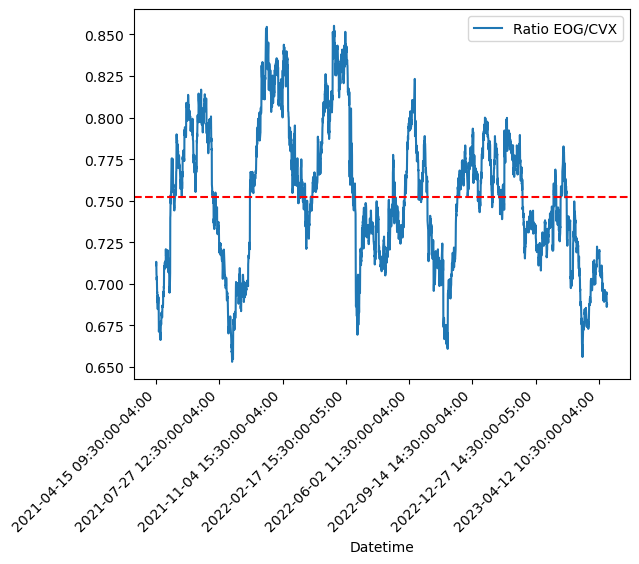

In [28]:
ratio_h, fig = ratio_calculation_and_plot('EOG','CVX',df_train_h_stat)

In [29]:
stationarity_test(ratio_h)

p-value = 0.0186 The series Ratio EOG/CVX is likely stationary.


From the graph above and the repsective p-value we can see that the ratio between EOG and CVX is stationary.

We can say with 2% confidence that our pair's ratio EOG/CVX is stationary process.


## Daily EDA

In [30]:
# Load csv of train data
df_train_d = pd.read_csv('data/pair_train_daily.csv', index_col=0, parse_dates=True)

# Set index to date column
df_train_d.set_index('Date', inplace=True)

df_train_d.tail()


/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_64979/1272588450.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



COP        CVX        EOG        EPD        OXY         PXD  \
Date                                                                            
2016-10-12  34.438953  74.355476  75.499229  15.836150  59.127079  148.010971   
2016-10-13  33.586349  73.365509  75.002876  15.807073  59.047195  145.878922   
2016-10-14  33.203854  73.576576  74.201813  15.638418  58.503872  144.173279   
2016-10-17  32.749676  73.780396  73.652031  15.463948  57.904594  142.870758   
2016-10-18  32.391106  74.093422  73.141533  15.719840  57.984497  142.676910   

                  SLB        XOM        SP500  
Date                                           
2016-10-12  65.748810  61.289017  2139.179932  
2016-10-13  65.821449  60.888065  2132.550049  
2016-10-14  65.651924  60.874016  2132.979980  
2016-10-17  65.377419  60.874016  2126.500000  
2016-10-18  65.708427  61.035774  2139.600098

In [31]:
fig1 = px.line(df_train_d, x=df_train_d.index, y=df_train_d.columns, labels={'value': 'Adjusted Close Price', 'variable': 'Ticker'})
fig1.update_layout(title='Adjusted Daily Close Prices of Selected Stocks and S&P 500',
                  xaxis_title='Date',
                  yaxis_title='Adjusted Close Price')

# Show the interactive plot
fig1.show()

### Correlation test

In [32]:
# Make a copy of dataframe without column SP500 for statistical tests
df_train_d_stat = df_train_d.drop(columns='SP500')

The top 5 pairs and their correlations are shown below in the heatmap

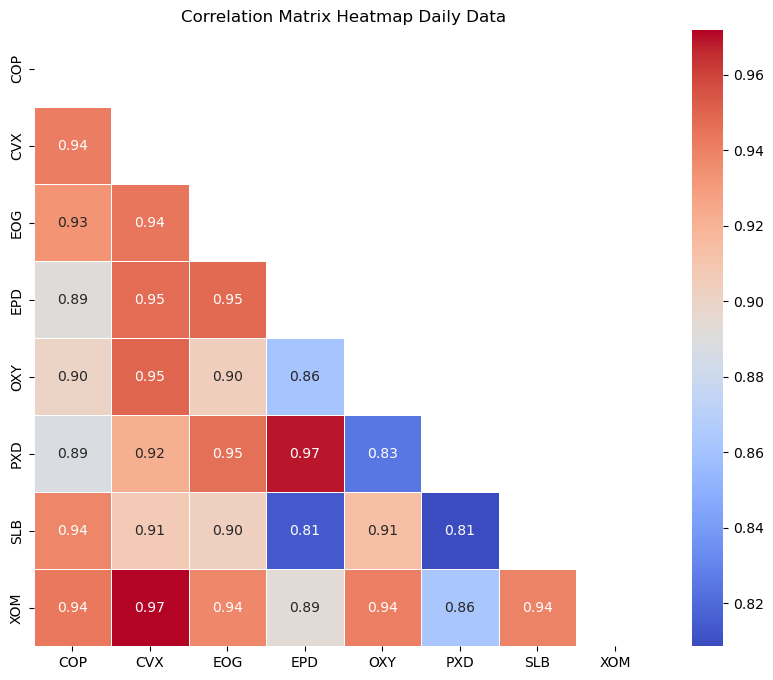

Top 5 Pairs Based on Correlation Score:
         pair  Correlation score
0  (XOM, CVX)           0.971744
1  (PXD, EPD)           0.969016
2  (OXY, CVX)           0.949692
3  (EPD, EOG)           0.948734
4  (EPD, CVX)           0.947308


In [33]:
corr_matrix_daily = df_train_d_stat.corr()


# Exclude diagonal and upper triangle
mask = np.triu(np.ones_like(corr_matrix_daily, dtype=bool))
corr_matrix_daily = corr_matrix_daily.mask(mask)

# Plot correlation matric heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_daily, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap Daily Data')
plt.show()


# Find the top 3 pairs based on correlation score
top_pairs_cor_d = (corr_matrix_daily.abs().stack()
              .sort_values(ascending=False)
              .head(5)
              .reset_index()
              .rename(columns={'level_0': 'Pair1', 'level_1': 'Pair2', 0: 'Correlation score'}))

top_pairs_cor_d['pair'] = top_pairs_cor_d.apply(lambda row: (row['Pair1'], row['Pair2']), axis=1)

# Print the top 5 pairs (lowest p-value)
print("Top 5 Pairs Based on Correlation Score:")
print(top_pairs_cor_d[['pair', 'Correlation score']])

### Cointegration test

The top 3 pairs and their cointegrations is shown below in the heatmap.

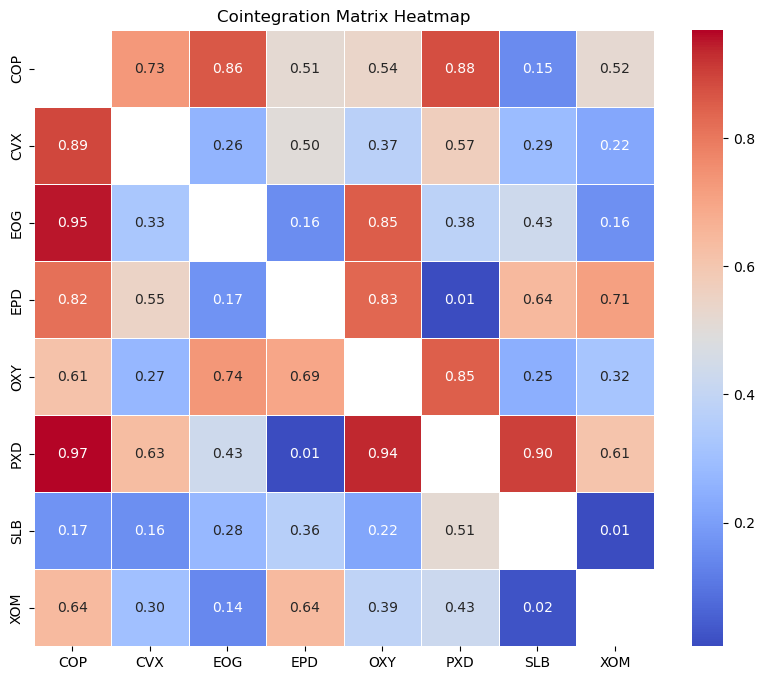

Top 3 Pairs Based on Cointegration Score:
         pair   P-value
0  (EPD, PXD)  0.007029
1  (PXD, EPD)  0.008730
2  (SLB, XOM)  0.008824


In [34]:
columns = df_train_d_stat.columns

# Initialize a matrix to store cointegration test results
coint_matrix_daily = pd.DataFrame(index=columns, columns=columns)

# Perform cointegration tests for all pairs (cointegration test is not a symethrical test)
for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            t,p,_ = ts.coint(df_train_d_stat[col1], df_train_d_stat[col2])
            coint_matrix_daily.loc[col1, col2] = p

# Transform to numeric 
coint_matrix_daily = coint_matrix_daily.apply(pd.to_numeric, errors='coerce')


# Plot correlation matric heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(coint_matrix_daily, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Cointegration Matrix Heatmap')
plt.show()

# Find the top 3 pairs based on cointegration score
top_pairs_coint_d = (coint_matrix_daily.abs().stack()
              .sort_values(ascending=True)
              .head(3)
              .reset_index()
              .rename(columns={'level_0': 'Pair1', 'level_1': 'Pair2', 0: 'P-value'}))

top_pairs_coint_d['pair'] = top_pairs_coint_d.apply(lambda row: (row['Pair1'], row['Pair2']), axis=1)

# Print the top 3 pairs (lowest p-value)
print("Top 3 Pairs Based on Cointegration Score:")
print(top_pairs_coint_d[['pair', 'P-value']])

In [35]:
# Extract pairs from both DataFrames
pairs_df1 = set(top_pairs_cor_d['pair'])
pairs_df2 = set(top_pairs_coint_d['pair'])

# Find common pairs
common_pairs = pairs_df1.intersection(pairs_df2)

# Print common pairs
print("Common Pairs:")
for pair in common_pairs:
    print(pair)

Common Pairs:
('PXD', 'EPD')


The top pair that we find for both correlation and cointegration test is PXD and EPD.

### Stationarity - Augmented Dickey Fuller test

In [36]:
# Check for stationarity in our stocks
for ticker in df_train_d_stat.columns:
    stationarity_test(df_train_d_stat[ticker])

p-value = 0.4726 The series COP is likely non-stationary.
p-value = 0.8446 The series CVX is likely non-stationary.
p-value = 0.8851 The series EOG is likely non-stationary.
p-value = 0.9224 The series EPD is likely non-stationary.
p-value = 0.6465 The series OXY is likely non-stationary.
p-value = 0.8869 The series PXD is likely non-stationary.
p-value = 0.5251 The series SLB is likely non-stationary.
p-value = 0.7925 The series XOM is likely non-stationary.


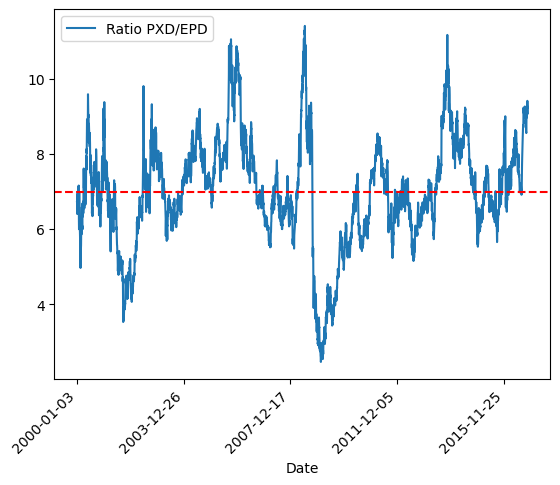

In [37]:
ratio_d, fig_d = ratio_calculation_and_plot('PXD','EPD',df_train_d_stat)

In [38]:
stationarity_test(ratio_d)

p-value = 0.0027 The series Ratio PXD/EPD is likely stationary.


As seen for the hourly data, the test on the single stocks result in non-stationarity while the test for the ratio between the top pair (PXD/EPD) is stationary.

# 4. Strategy

We based our strategy on a z-score of lagged price ratio. In order to get optimal thresholds for opening a certain position we constructed a function that went long on one stock and shorted second one at the same time and ran a loop of different combinations of upper and lower thresholds. At the end we selected a pair that produced the highest portfolio value at the end of training period. The signal for triggering a certain trade was when z-score crossed pre-set thresholds. 

## Standardization: Z-score

A z-score is the number of standard deviations a data point is from the mean. More importantly, the number of standard deviations above or below the population mean is from the raw score. The z-score is calculated by the follow:

$$\mathcal{z}_{i} = \frac{x_{i} - \bar{x}}{s}$$

### Hourly Strategy

In [39]:
# We lag prices to avoid bias of seeing end of the day prices at the begining of the day
df_eog_cvx = df_train_h_stat[['EOG', 'CVX']].copy()

df_eog_cvx['lag_EOG'] = df_eog_cvx['EOG'].shift(1)

df_eog_cvx['lag_CVX'] = df_eog_cvx['CVX'].shift(1)
df_eog_cvx = df_eog_cvx.dropna()



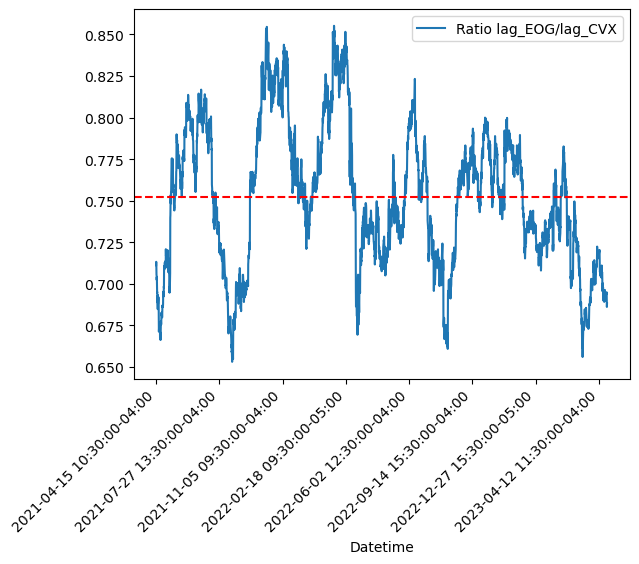

In [40]:
ratio_h_lagged,_ = ratio_calculation_and_plot('lag_EOG','lag_CVX',df_eog_cvx)

In [41]:
# Z score calculation
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [42]:
# Z score calculation with mooving averages
def zscore_mooving(series):
    # Ratios_mavg5 = series.rolling(window=5, center=False).mean()
    ratios_mavg150 = series.rolling(window=150, center=False).mean()
    std_150 = series.rolling(window=150, center=False).std()
    zscore_150 = (series - ratios_mavg150)/std_150
    return zscore_150

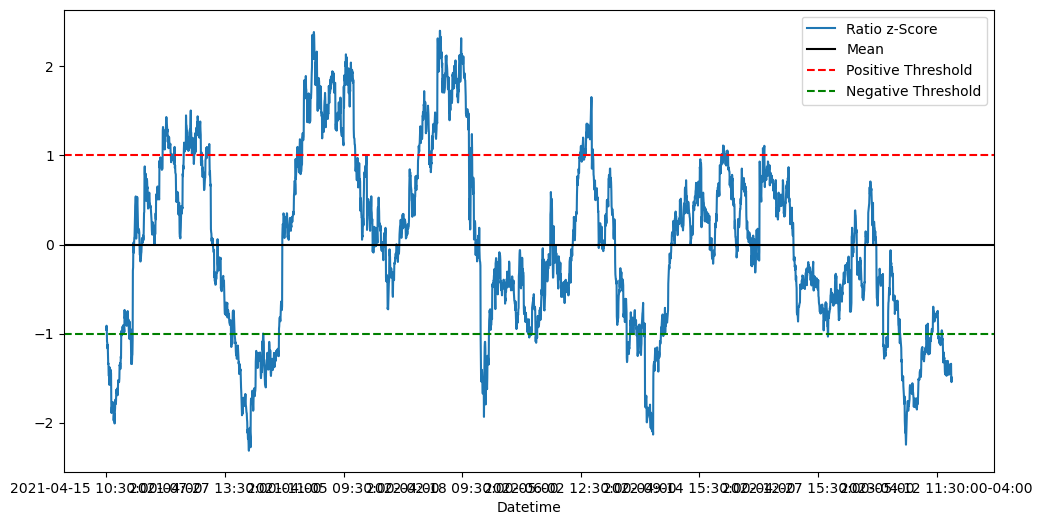

In [43]:
zscore_h = zscore(ratio_h_lagged)
zscore_h.name = f'Z-score {ratio_h.name[-7:]}'


zscore_h.plot(figsize=(12,6))
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-Score', 'Mean','Positive Threshold', 'Negative Threshold'])

plt.show()

By setting two other lines placed at the z-score of 1 and -1, we can clearly see that for the most part, any big divergences from the mean eventually converges back. This is exactly what we want for a pairs trading strategy.

In [44]:
df_ret_h = df_long_h[(df_long_h['ticker'] == "EOG")|(df_long_h['ticker'] == "CVX")]
df_ret_h = df_ret_h.drop(columns='price')

In [45]:
wide_df_h = df_ret_h.pivot(columns='ticker', values=['ret', 'cum_ret'])

# Assuming wide_df is your DataFrame with multi-level columns
wide_df_h.columns = [f'{ticker}_{col}' if col != '' else col for col, ticker in wide_df_h.columns]


In [46]:
zscore_h = pd.DataFrame(zscore_h)

# Combine zscore, and prices lagged in one table
df_eog_cvx = df_eog_cvx[["lag_EOG", "lag_CVX"]]
df_strategy = pd.merge(df_eog_cvx, zscore_h, left_index=True, right_index=True)
df_strategy = pd.merge(df_strategy,wide_df_h,left_index=True, right_index=True)


## Beta Neutral Pair Trading

When setting the positions the trader must balance out the difference in value of each company share.

A naive strategy would be to balance out by quantity only. 

<br>

\begin{equation*}
n\_shares_{company\_a} * shares\_price_{company\_a} = n\_shares_{company\_b} * shares\_price_{company\_b}
\end{equation*}

<br>

That would be ok if both companies grew at the same rate. However in reality it doesn't happen.

A more sophisticated strategy would be to try to approximate a linear relatioship of both distributions.

<br>

\begin{equation*}
lin\_coef = argmin(error({x}*shares\_price_{company\_a} , shares\_price_{company\_b}))
\end{equation*}

<br>

\begin{equation*}
lin\_coef*n\_shares_{company\_a} * shares\_price_{company\_a} = n\_shares_{company\_b} * shares\_price_{company\_b}
\end{equation*}

<br>

That is actually a good method. Nonetheless, keeping in mind that the goal of this strategy is to reduce the market risk there is a financial indicator that was better designed to measure market risk, the [**Beta**](https://www.investopedia.com/terms/b/beta.asp) indicator. 

<br>

\begin{equation*}
\beta_a * n\_shares_{company\_a} * shares\_price_{company\_a} = \beta_b * n\_shares_{company\_b} * shares\_price_{company\_b}
\end{equation*}

<br>

We took betas for all companies from Refinitiv Eikon.

- Beta [Chevron Corporation]: 1.12
- Beta [EOG Resources Inc]: 1.39
- Beta [Pioneer Natural Resources Company]: 1.33
- Beta [Enterprise Products Partners L.P.]: 0.98

In [47]:
# Betas
beta_CVX = 1.12
beta_EOG = 1.39

position_encoding = {
    0 : 'no positions',
    1 : 'long on EOG & short on CVX',
    2 : 'long on CVX & short on EOG'}


In [48]:
# This function returns the numbers of shares to trade from each company
# In this case we will fix the number of CVX's shares to 1000 and round up
# The equivalent number of EOG's shares to the closest int. 
def get_number_of_shares(ts1, ts2, time):
  ratio = ts2[time]/ts1[time] * beta_CVX/beta_EOG
  return np.rint(100*ratio), 100

In [49]:
def strategy_simulation(ticker1, ticker2, df, upper_threshold, lower_threshold):
    # Portfolio value over time
    # It equals the total plus the position value
    portfolio_value = []

    # Current total
    total = 0
    current_position = 0  # Starts with no position
    
    # Number of shares
    n_EOG = 0 
    n_CVX = 0

    # Stock prices
    ts1 = df[f'lag_{ticker1}']
    ts2 = df[f'lag_{ticker2}']
    
    position_history = []
    # Strategy simulation script
    for i, z in enumerate(df_strategy[f'Z-score {ticker1}/{ticker2}']):
      # If has position check if should quit
      if current_position == 1:
        # Condition to quit long EOG short CVX
        if z >= 0:
          total += ts1[i] * n_EOG
          total -= ts2[i] * n_CVX
          n_EOG = 0
          n_CVX = 0
          current_position = 0
      elif current_position == 2:
        # Condition to quit long CVX short EOG
        if z <= 0:
          total -= ts1[i] * n_EOG
          total += ts2[i] * n_CVX
          n_EOG = 0
          n_CVX = 0
          current_position = 0
    
      # If has no position check if should enter
      # Note that this allows to switch positions
      if current_position == 0:
        # Condition to enter long CVX short EOG
        if z >= upper_threshold:
          n_EOG, n_CVX = get_number_of_shares(ts1=ts1, ts2=ts2, time=i)
          total += ts1[i] * n_EOG
          total -= ts2[i] * n_CVX
          current_position = 2
        # Condition to enter long EOG short CVX
        elif z <= lower_threshold:
          n_EOG, n_CVX = get_number_of_shares(ts1=ts1, ts2=ts2, time=i)
          total -= ts1[i] * n_EOG
          total += ts2[i] * n_CVX
          current_position = 1

      # Register position
      position_history.append(current_position)

      # Compute current portfolio value 
      current_portfolio_value = total
      # If long EOG short CVX
      if current_position == 1:
        current_portfolio_value += n_EOG * ts1[i]
        current_portfolio_value -= n_CVX * ts2[i]
      # If long CVX short EOG
      elif current_position == 2:
        current_portfolio_value -= n_EOG * ts1[i]
        current_portfolio_value += n_CVX * ts2[i]
      # Register current portfolio value
      portfolio_value.append(current_portfolio_value)
    current_position = 0
    total = 0

  # Print('Final portfolio value: %.2F' % portfolio_value[-1])

    # Create data frame of portfolio value
    df_portfolio_value = pd.DataFrame(portfolio_value, columns=['value'])
    df_position_history = pd.DataFrame(position_history, columns=['pos'])
    # Print('Final portfolio value: %.2F' % portfolio_value[-1])
    portfolio_value.clear()
    return df_portfolio_value, df_position_history



In [50]:
def strategy_simulation_fees(ticker1, ticker2, df, upper_threshold, lower_threshold, max_holding_period=60):
    # Portfolio value over time
    portfolio_value = []

    # Returns
    returns = []
    # Current total
    total = 0
    current_position = 0  # Starts with no position
    
    # Number of shares
    n_EOG = 0 
    n_CVX = 0

    # Stock prices
    ts1 = df[f'lag_{ticker1}']
    ts2 = df[f'lag_{ticker2}']
    
    position_history = []
    # Strategy simulation script
    holding_period = 0  # Initialize holding period counter
    
    for i, z in enumerate(df[f'Z-score {ticker1}/{ticker2}']):
        # If has position, check if should quit
        if current_position == 1:
            # Condition to quit long EOG short CVX
            if z >= 0 or holding_period >= max_holding_period:
                total += ts1[i] * n_EOG * (1 - 0.001)  # 0.1% fee for long position
                total -= ts2[i] * n_CVX * (1 + 0.002)  # 0.2% fee for short position
                n_EOG = 0
                n_CVX = 0
                current_position = 0
                holding_period = 0  # Reset holding period counter
        elif current_position == 2:
            # Condition to quit long CVX short EOG
            if z <= 0 or holding_period >= max_holding_period:
                total -= ts1[i] * n_EOG * (1 + 0.001)  # 0.1% fee for long position
                total += ts2[i] * n_CVX * (1 - 0.002)  # 0.2% fee for short position
                n_EOG = 0
                n_CVX = 0
                current_position = 0
                holding_period = 0  # Reset holding period counter
    
        # If has no position, check if should enter
        # Note that this allows switching positions
        if current_position == 0:
            # Condition to enter long CVX short EOG
            if z >= upper_threshold:
                n_EOG, n_CVX = get_number_of_shares(ts1=ts1, ts2=ts2, time=i)
                total += ts1[i] * n_EOG * (1 - 0.001)  # 0.1% fee for long position
                total -= ts2[i] * n_CVX * (1 + 0.002)  # 0.2% fee for short position
                current_position = 2
                holding_period = 1  # Initialize holding period counter
            # Condition to enter long EOG short CVX
            elif z <= lower_threshold:
                n_EOG, n_CVX = get_number_of_shares(ts1=ts1, ts2=ts2, time=i)
                total -= ts1[i] * n_EOG * (1 + 0.001)  # 0.1% fee for long position
                total += ts2[i] * n_CVX * (1 - 0.002)  # 0.2% fee for short position
                current_position = 1
                holding_period = 1  # Initialize holding period counter
        else:
            # Increment holding period if there is an open position
            holding_period += 1

        # Register position
        position_history.append(current_position)

        # Compute current portfolio value 
        current_portfolio_value = total
        # If long EOG short CVX
        if current_position == 1:
            current_portfolio_value += n_EOG * ts1[i] 
            current_portfolio_value -= n_CVX * ts2[i] 
        # If long CVX short EOG
        elif current_position == 2:
            current_portfolio_value -= n_EOG * ts1[i] 
            current_portfolio_value += n_CVX * ts2[i] 
            
        #we update list of cumulative portfolio value
        portfolio_value.append(current_portfolio_value)

    current_position = 0
    total = 0

    
    # Create data frame of portfolio value
    df_portfolio_value = pd.DataFrame(portfolio_value, columns=['value'])
    df_position_history = pd.DataFrame(position_history, columns=['pos'])

    #clear list so that if we run function multiple times we get correct results and not appending to preexisting situation
    portfolio_value.clear()
    return df_portfolio_value, df_position_history


In [51]:
# Create a sequence from -0.5 to -1.5 with step 0.1
lower_threshold = np.linspace(-0.5, -1.5, num=11)
# Create a sequence from 0.5 to 1.5 with step 0.1
upper_threshold = np.linspace(0.5, 1.5, num=11)

# Create pairs: each short assign to each long
pairs = [(l, u) for l in lower_threshold for u in upper_threshold]

In [52]:
# Parameters search
results = {}

# Loop over pairs
for l,u in pairs:
  df_portfolio_value,_ = strategy_simulation_fees('EOG', 'CVX', df_strategy, u, l)

  final_value = df_portfolio_value['value'].iloc[-1]
  results[(l,u)] = final_value


/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_64979/3327359847.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_64979/833252827.py:57: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_64979/833252827.py:58: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipy

We computed two different versions of our strategy, one including fees and the other one not including them.
The results are listed below for the different thresholds.

In [53]:
# Print results
for k, v in results.items():
  print(f'{k}: {v:.4f}')

max_key = max(results, key=lambda k: results[k])
max_value = results[max_key]

print(10*'****')

print(f"Max Portfolio Value: {max_value} for parameters {max_key}")

(-0.5, 0.5): 4923.7844
(-0.5, 0.6): 5297.3968
(-0.5, 0.7): 5375.5537
(-0.5, 0.8): 6069.5030
(-0.5, 0.9): 4108.8307
(-0.5, 1.0): 5039.6877
(-0.5, 1.1): 5006.1741
(-0.5, 1.2000000000000002): 3878.8883
(-0.5, 1.3): 4461.8675
(-0.5, 1.4): 4397.2357
(-0.5, 1.5): 4315.4370
(-0.6, 0.5): 6258.5835
(-0.6, 0.6): 6632.1959
(-0.6, 0.7): 6710.3528
(-0.6, 0.8): 7404.3021
(-0.6, 0.9): 5443.6298
(-0.6, 1.0): 6374.4868
(-0.6, 1.1): 6340.9733
(-0.6, 1.2000000000000002): 5213.6874
(-0.6, 1.3): 5796.6666
(-0.6, 1.4): 5732.0349
(-0.6, 1.5): 5650.2361
(-0.7, 0.5): 5335.1162
(-0.7, 0.6): 5708.7286
(-0.7, 0.7): 5786.8855
(-0.7, 0.8): 6480.8348
(-0.7, 0.9): 4520.1625
(-0.7, 1.0): 5451.0195
(-0.7, 1.1): 5417.5059
(-0.7, 1.2000000000000002): 4290.2201
(-0.7, 1.3): 4873.1993
(-0.7, 1.4): 4808.5676
(-0.7, 1.5): 4726.7688
(-0.8, 0.5): 4629.0706
(-0.8, 0.6): 5002.6829
(-0.8, 0.7): 5080.8398
(-0.8, 0.8): 5774.7891
(-0.8, 0.9): 3814.1168
(-0.8, 1.0): 4744.9739
(-0.8, 1.1): 4711.4603
(-0.8, 1.2000000000000002): 3584.17

In [54]:
#get optimal thresholds
lower_max, upper_max = max_key

# Add datetime index to our portfolio value df
df_portfolio_value_max, df_position_history_max= strategy_simulation_fees('EOG', 'CVX', df_strategy, upper_max, lower_max)
df_portfolio_value_max.index = zscore_h.index
df_position_history_max.index = zscore_h.index

df_profit_plot_h = pd.merge(df_portfolio_value_max,df_position_history_max, left_index=True, right_index=True )

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_64979/3327359847.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_64979/833252827.py:57: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_64979/833252827.py:58: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipy

The graph below represents the portfolio value over time based on the optimal threshold chosen before. It can be observed that to reach this portfolio value many operations would be needed, but this could be explained by the short time-frame (one hour) used.

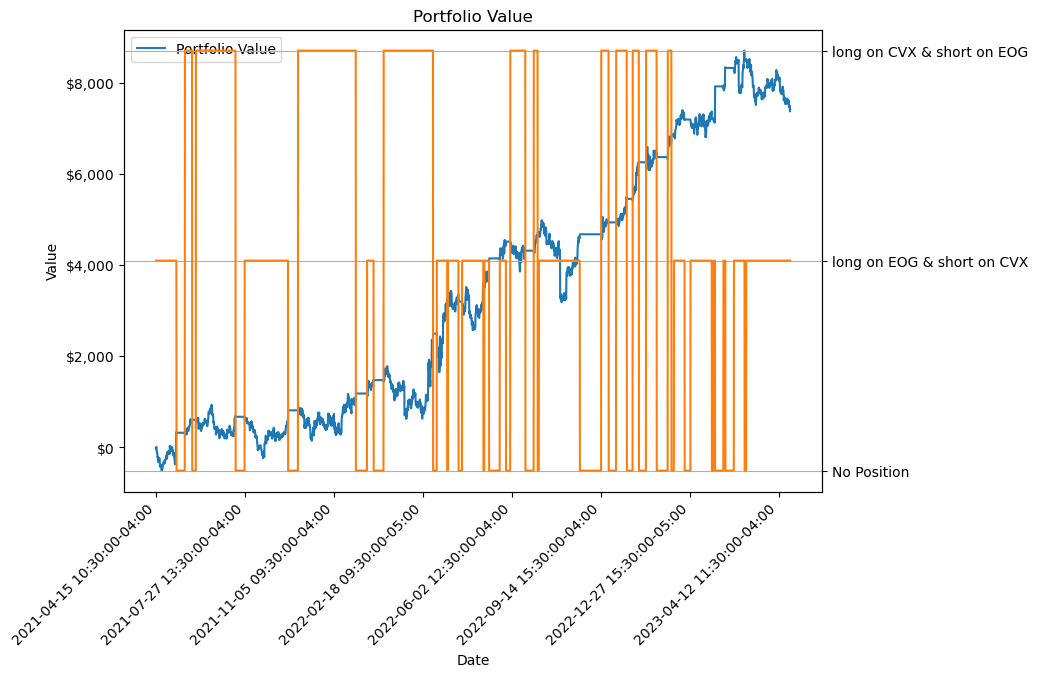

In [56]:
# Plot results
ax = df_profit_plot_h.plot(figsize=(9, 6), secondary_y='pos', title='Portfolio Value', grid=True)

# Adding labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend(['Portfolio Value'], loc='upper left')

# Set y-axis ticks and labels
plt.yticks([0, 1, 2], ['No Position', position_encoding[1], position_encoding[2]])

# Rotate x-axis labels at a 45-degree angle
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Formatting y-axis labels with the dollar sign and comma separators
ax.yaxis.set_major_formatter('${x:,.0f}')

plt.show()


In [57]:
df_sp = pd.DataFrame(df_long_h[df_long_h.ticker == 'SP500']['cum_ret'])
df_sp['benchmark'] = 1000*df_sp.cum_ret

In [58]:
n_eog, n_cvx = get_number_of_shares(df_strategy['lag_EOG'], df_strategy['lag_CVX'], time=df_strategy.index[0])
#df_portfolio_value_max['benchmark'] = n_eog/10*df_strategy['lag_EOG'] + n_cvx/10*df_strategy['lag_CVX']
df_portfolio_value_max['SP500'] = df_sp['benchmark']

It can be easily noted that our portfolio value, even after so many trading fees, is way higher than the benchmark S&P 500. Here we need to take into consideration the amount of risk and exposure we are taking with our strategy that is much higher than buy-and-hold one used in benchmark.

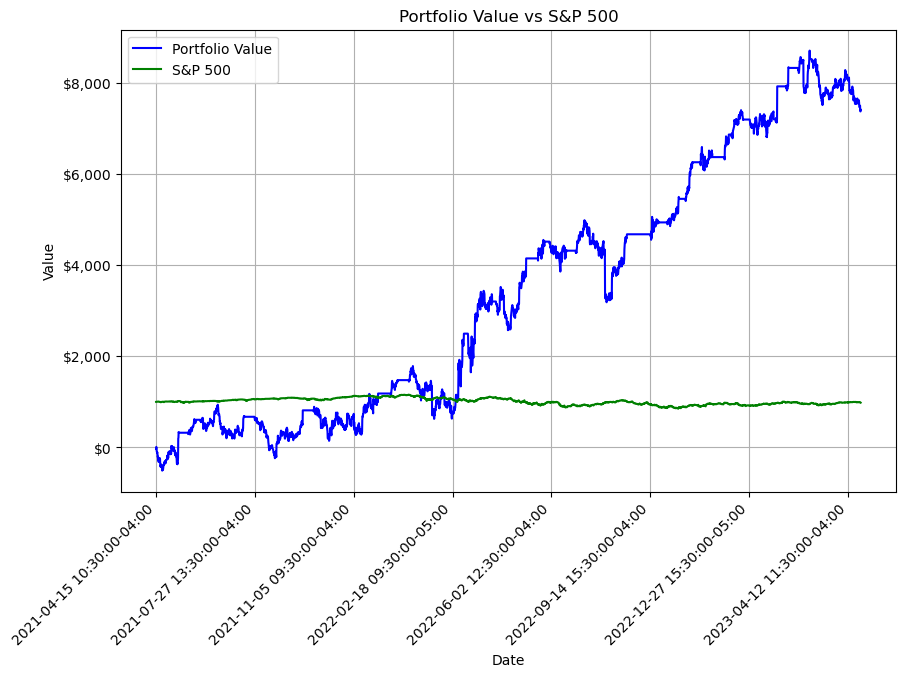

In [59]:

ax = df_portfolio_value_max[['value', 'SP500']].plot(figsize=(10, 6), title='Portfolio Value vs Benchmark', color=['blue', 'green'])

# Adding labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend(['Portfolio Value', 'S&P 500'], loc='upper left')

# Adding grid lines for better readability
ax.grid(True)

# Rotating x-axis labels at a 45-degree angle
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Formatting y-axis labels with the dollar sign and comma separators
ax.yaxis.set_major_formatter('${x:,.0f}')

# Adding a title
plt.title('Portfolio Value vs S&P 500')

# Displaying the plot
plt.show()




In [60]:
# df_portfolio_value_max['ret_port'] = df_portfolio_value_max['value'].pct_change()
# Compute cumulative returns
# df_portfolio_value_max['cumret_port'] = (1 + df_portfolio_value_max['ret_port']).cumprod()

In [61]:
#construct dataframe to plot positions with our signal (z-score) in order to analyze our losses in periods of bigger drops
df_zscore_pos = pd.merge(zscore_h, df_position_history_max, left_index=True, right_index=True)


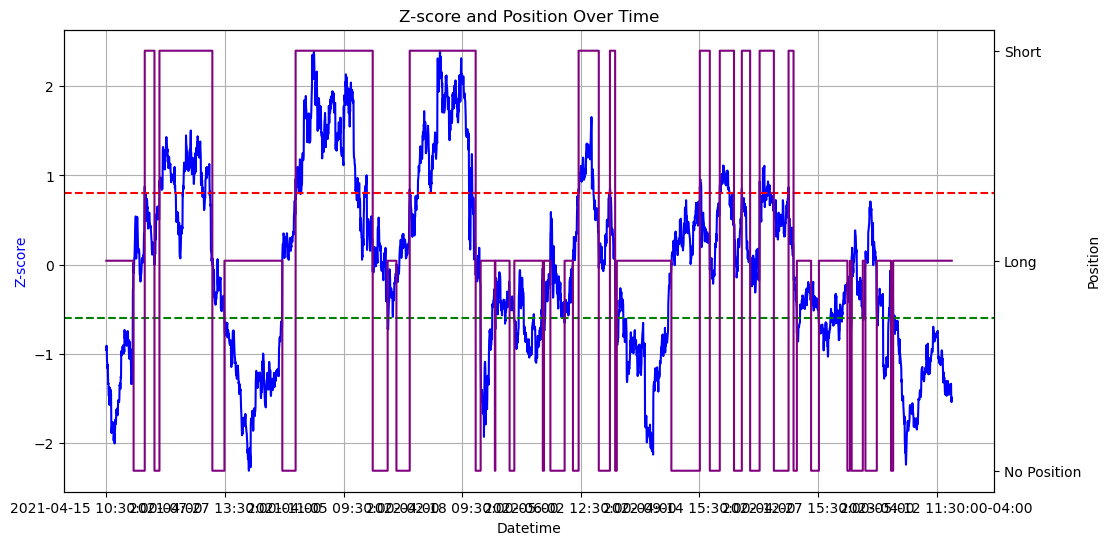

In [62]:
# Plot results
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the zscore on the primary y-axis
df_zscore_pos['Z-score EOG/CVX'].plot(ax=ax1, color='blue', label='Z-score', grid=True)
ax1.set_ylabel('Z-score', color='blue')

# Add horizontal lines to the primary y-axis
ax1.axhline(y=upper_max, color='red', linestyle='--', label='Upper Threshold')
ax1.axhline(y=lower_max, color='green', linestyle='--', label='Lower Threshold')

# Overlay a secondary y-axis for position
ax2 = ax1.twinx()
ax2.step(df_zscore_pos.index, df_zscore_pos['pos'], where='post', color='purple', label='Position')

# Set y-axis ticks and labels for the secondary axis
ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(['No Position', 'Long', 'Short'])

ax2.set_ylabel('Position')

plt.title('Z-score and Position Over Time')
plt.show()

In [75]:
# to check below in graph what was going on with both stocks in times when we accumulated bigegst losses 
# for possible explenations and improvement ideas that we state at the end


df_cvxeog = df_strategy[['lag_EOG','lag_CVX']]
df_cvxeog_pos = pd.merge(df_cvxeog, df_position_history_max, left_index=True, right_index=True)

([<matplotlib.axis.YTick at 0x16c1f2410>,
 [Text(1, 0, 'No Position'),
  Text(1, 1, 'long on EOG & short on CVX'),
  Text(1, 2, 'long on CVX & short on EOG')])

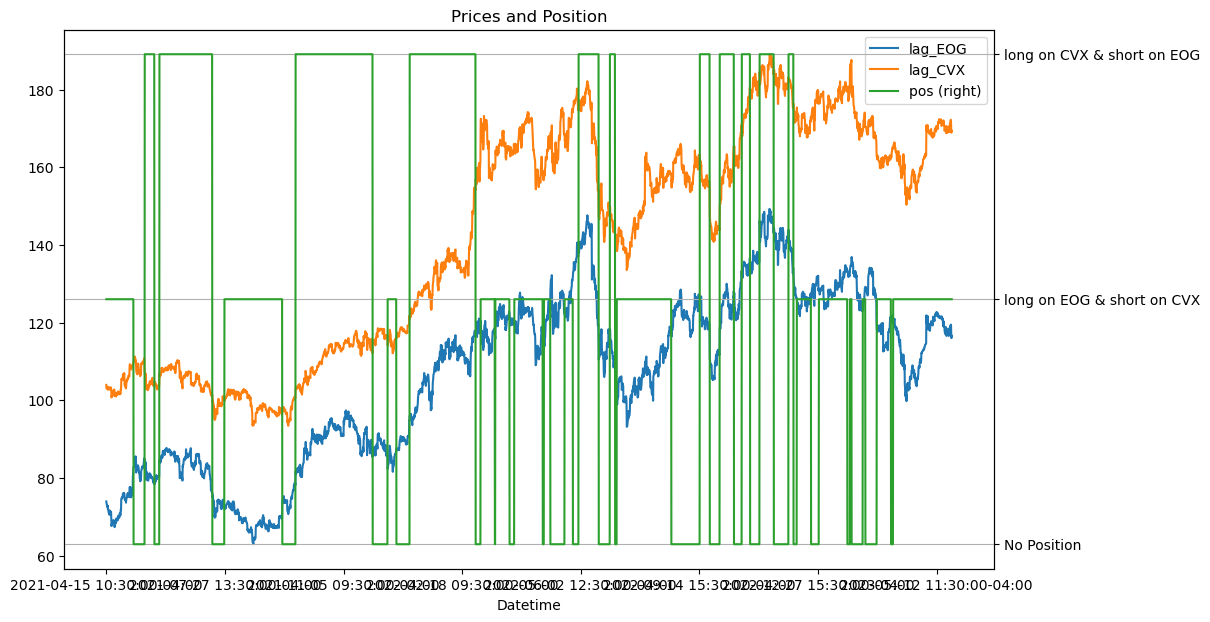

In [64]:
df_cvxeog_pos.plot(figsize=(12,7), secondary_y ='pos', title='Prices and Position', grid=True)
# Set y-axis ticks and labels
plt.yticks([0, 1, 2], ['No Position', position_encoding[1], position_encoding[2]])

## Daily Strategy

### Standardization: Z-score

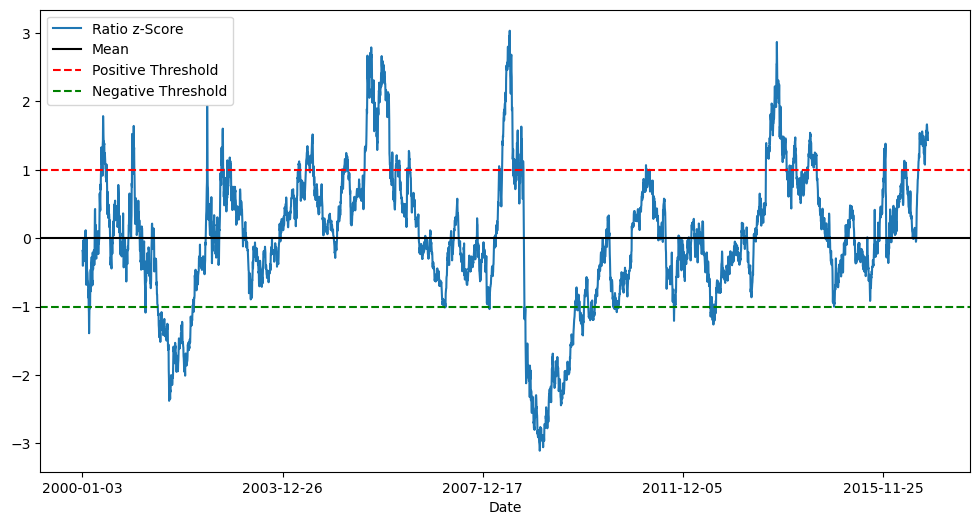

In [65]:
zscore_d = zscore(ratio_d)
zscore_d.name = f'Z-score {ratio_d.name[-7:]}'


zscore_d.plot(figsize=(12,6))
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-Score', 'Mean','Positive Threshold', 'Negative Threshold'])

plt.show()

# 5. Testing Strategy

Here we will be testing our strategy on hourly and daily time frames to see how we would have performed in real life scenario. 

## Hourly Testing

In [66]:
# Load csv of train data
df_test_h = pd.read_csv('data/pair_test_h.csv', index_col=0, parse_dates=True)

# Set index to date column
df_test_h.set_index('Datetime', inplace=True)

df_test_h.head()

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_64979/1335222314.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



COP         CVX         EOG        EPD  \
Datetime                                                                   
2023-04-25 13:30:00-04:00  101.769997  169.375000  116.930000  26.600000   
2023-04-25 14:30:00-04:00  101.709999  169.059998  116.705002  26.645000   
2023-04-25 15:30:00-04:00  102.089996  169.000000  116.680000  26.639999   
2023-04-26 09:30:00-04:00  100.505997  166.820007  115.192703  26.549299   
2023-04-26 10:30:00-04:00  101.660004  168.339996  116.839996  26.665001   

                                  MPC        OXY        PSX         PXD  \
Datetime                                                                  
2023-04-25 13:30:00-04:00  123.209999  61.450001  99.849998  223.483994   
2023-04-25 14:30:00-04:00  123.099998  61.270000  99.629997  222.470001   
2023-04-25 15:30:00-04:00  123.150002  61.320000  99.320000  222.460007   
2023-04-26 09:30:00-04:00  122.065002  60.334999  98.923698  221.020004   
2023-04-26 10:30:00-04:00  123.260002  60.750000  99.754997  222.395996   

                                 SLB         XOM        SP500  
Datetime                                                       
2023-04-25 13:30:00-04:00  48.980000  116.510002  4082.919922  
2023-04-25 14:30:00-04:00  48.955002  116.415001  4080.370117  
2023-04-25 15:30:00-04:00  48.959999  116.519997  4071.979980  
2023-04-26 09:30:00-04:00  48.189999  114.885002  4065.070068  
2023-04-26 10:30:00-04:00  48.849998  116.300003  4082.959961

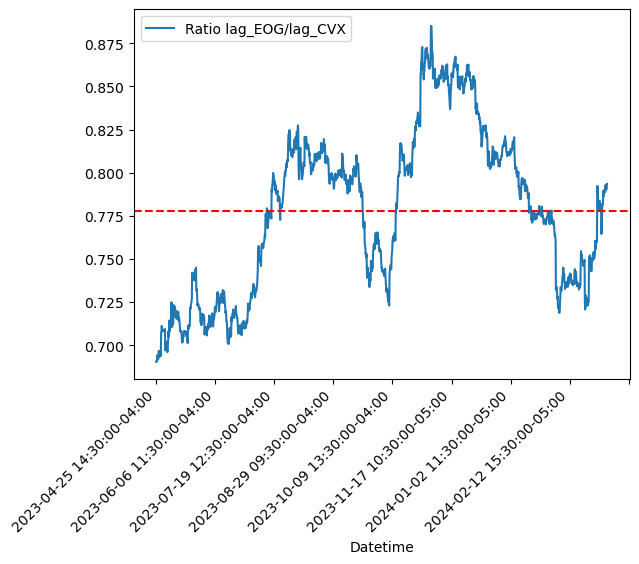

In [67]:
#df_test_h_lagged = df_test_h[['EOG', 'CVX']].copy()
df_test_h_lagged = pd.DataFrame()
df_test_h_lagged['lag_EOG'] = df_test_h['EOG'].shift(1)
df_test_h_lagged['lag_CVX'] = df_test_h['CVX'].shift(1)

#drop missing values after shifting
df_test_h_lagged = df_test_h_lagged.dropna()


#get ratio of lagged prices
ratio_test_h_lagged,_ = ratio_calculation_and_plot('lag_EOG','lag_CVX',df_test_h_lagged)



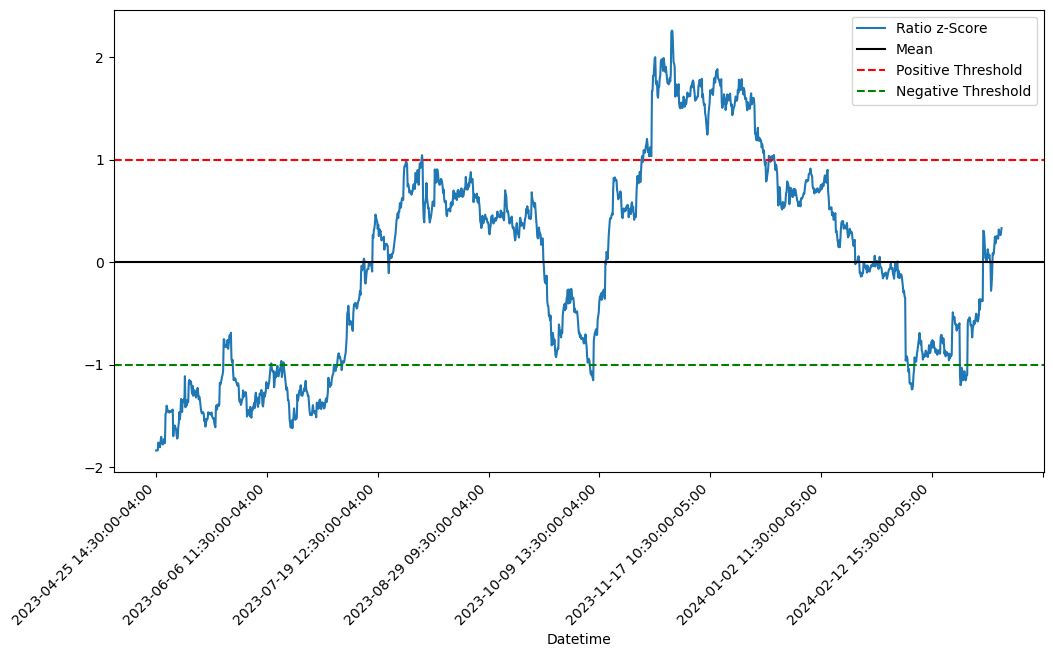

In [68]:
#zscore of ratio lagged

df_test_zscore_h = zscore(ratio_test_h_lagged)
df_test_zscore_h.name = f'Z-score {ratio_h.name[-7:]}'

df_test_zscore_h.plot(figsize=(12, 6))
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-Score', 'Mean', 'Positive Threshold', 'Negative Threshold'])

# Rotate x-axis labels at a 45-degree angle
plt.xticks(rotation=45, ha='right')

plt.show()


In [69]:
#create data frame for our strategy function
df_test_zscore_h = pd.DataFrame(df_test_zscore_h)
df_strategy_test_h = pd.merge(df_test_h_lagged, df_test_zscore_h, left_index=True, right_index=True)


In [70]:
# Add datetime index to our portfolio value df
df_test_portfolio_h, df_test_position_history_h= strategy_simulation_fees('EOG', 'CVX', df_strategy_test_h, upper_max, lower_max)
df_test_portfolio_h.index = df_strategy_test_h.index
df_test_position_history_h.index = df_strategy_test_h.index

df_test_profit_plot_h = pd.merge(df_test_portfolio_h,df_test_position_history_h, left_index=True, right_index=True )


/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_64979/3327359847.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_64979/833252827.py:57: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_64979/833252827.py:58: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipy

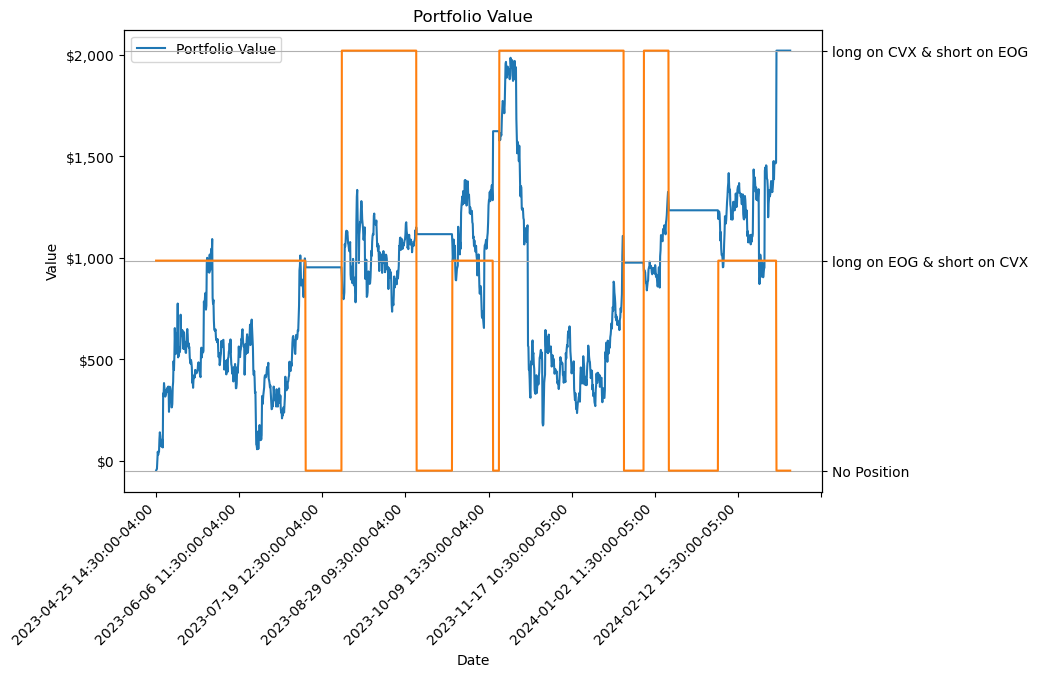

In [71]:
#plot our strategy's results of test period
# Plot results
ax = df_test_profit_plot_h.plot(figsize=(9, 6), secondary_y='pos', title='Portfolio Value', grid=True)

# Adding labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend(['Portfolio Value'], loc='upper left')

# Set y-axis ticks and labels
plt.yticks([0, 1, 2], ['No Position', position_encoding[1], position_encoding[2]])

# Rotate x-axis labels at a 45-degree angle
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Formatting y-axis labels with the dollar sign and comma separators
ax.yaxis.set_major_formatter('${x:,.0f}')

plt.show()

**Observation:**
We can see that there is a major area for improvement in terms of stop losses that could prevent us from accumulating a loss in period around 2023-11-16.

In [72]:
df_test_cvxeog = df_strategy_test_h[['lag_EOG','lag_CVX']]
df_test_cvxeog_pos = pd.merge(df_test_cvxeog, df_test_position_history_h, left_index=True, right_index=True)

([<matplotlib.axis.YTick at 0x16c638450>,
 [Text(1, 0, 'No Position'),
  Text(1, 1, 'long on EOG & short on CVX'),
  Text(1, 2, 'long on CVX & short on EOG')])

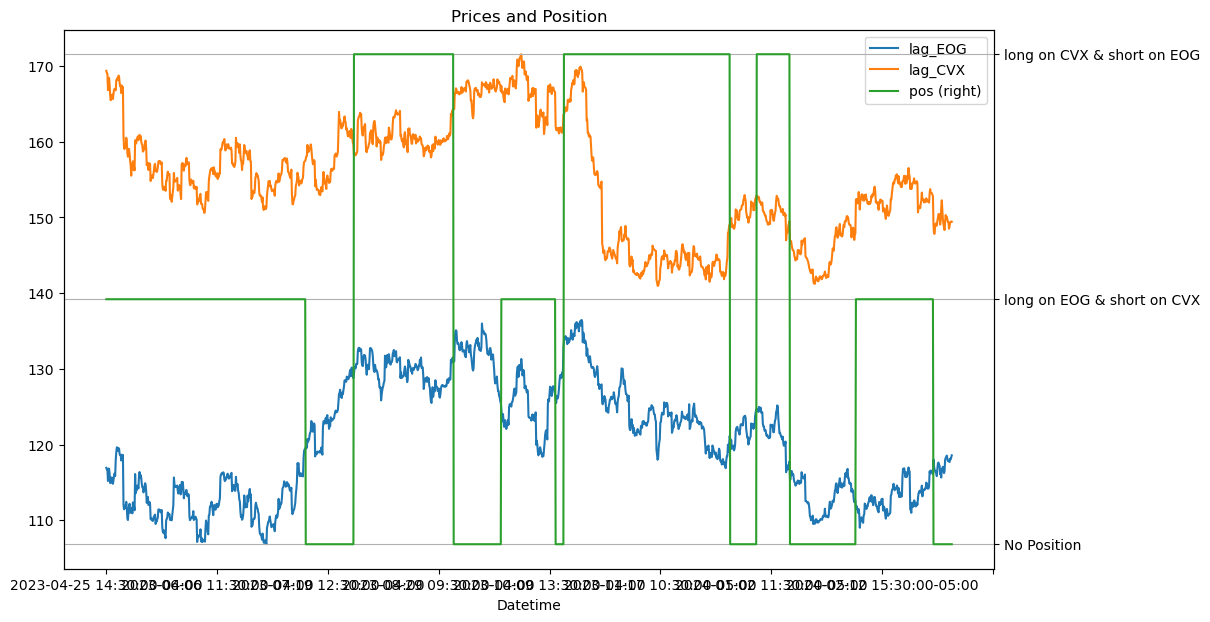

In [73]:
df_test_cvxeog_pos.plot(figsize=(12,7), secondary_y ='pos', title='Prices and Position', grid=True)
# Set y-axis ticks and labels
plt.yticks([0, 1, 2], ['No Position', position_encoding[1], position_encoding[2]])

We can see that the reason for loss is a major drop in price of CVX slightly after buying it and that loss was much bigger than gain from shorting EOG in the same period.

## Financial Report

### Hourly Financial Report

In [74]:
# Title
print('_________Portfolio report_________\n\n')

# Printing the final value of the portfolio
final_value = df_test_portfolio_h['value'].iloc[-1]
print(f'Final value:           $ {final_value:.2f} \n')

# Printing the maximum and minimum values of the portfolio
max_value = df_test_portfolio_h['value'].max()
min_value = df_test_portfolio_h['value'].min()
print(f'Max value:             $ {max_value:.2f}')
print(f'Min value:             $ {min_value:.2f}\n')

# Printing expected gain, max gain, max loss, and max cumulative gain
expected_gain = np.mean(np.diff(df_test_portfolio_h['value']))
max_gain = np.max(np.diff(df_test_portfolio_h['value']))
max_loss = np.min(np.diff(df_test_portfolio_h['value']))
print(f'Expected gain:         $ {expected_gain:.2f}')
print(f'Max gain:              $ {max_gain:.2f}')
print(f'Max loss:              $ {max_loss:.2f}\n')


# Printing max cumulated loss,gain and volatility (standard deviation)
max_cumulative_gain = np.max([np.max(df_test_portfolio_h['value'][i:]) - np.min(df_test_portfolio_h['value'][:i]) for i in range(1, len(df_test_portfolio_h)-1)])
cumulated_loss = np.min([np.min(df_test_portfolio_h['value'][i:]) - np.max(df_test_portfolio_h['value'][:i]) for i in range(1, len(df_test_portfolio_h)-1)])
volatility = np.std(np.diff(df_test_portfolio_h['value']))
print(f'Max cumulative gain:   $ {max_cumulative_gain:.2f}')
print(f'Max cumulated loss:    $ {cumulated_loss:.2f}')
print(f'Volatility (std):      $ {volatility:.2f}\n')


_________Portfolio report_________


Final value:           $ 2020.32 

Max value:             $ 2020.32
Min value:             $ -47.56

Expected gain:         $ 1.36
Max gain:              $ 551.24
Max loss:              $ -593.41

Max cumulative gain:   $ 2067.88
Max cumulated loss:    $ -1810.69
Volatility (std):      $ 55.14



### Areas of Improvement and Further Steps

This is by no means a perfect strategy and the implementation of our strategy isn't the best. However, there are several things that can be improved upon.

#### 1. Using more securities and more varied time ranges

For the pairs trading strategy cointegration test, we only used a handful of stocks. Naturally (and in practice) it would be more effective to use clusters within an industry.

#### 2. Dealing with overfitting

Anything related to data analysis and training models has much to do with the problem of overfitting. There are many different ways to deal with overfitting like validation, such as Kalman filters, and other statistical methods.

#### 3. Adjusting the trading signals

Our trading algorithm fails to account for stock prices that overlap and cross each other. Considering that the code only calls for a buy or sell given its ratio, it doesn't take into account which stock is actually higher or lower.

#### 4. More advanced methods

This is just the tip of the iceberg of what you can do with algorithmic pairs trading. It's simple because it only deals with moving averages and ratios. If you want to use more complicated statistics, feel free to do so. Other complex examples include subjects such as the Hurst exponent, half-life mean reversion, and Kalman Filters.

#### 5. Stop loss and margin requirement

In our project we haven't implemented stop loss which could be a useful next step in order to prevent big drops in portfolio value. Last but not least, we haven't taken into consideration the margin requirement in case of short positions thus making strategy less realistic.  